# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.126207,True,5.708383
1,0.194662,True,4.458799
2,-0.890225,False,-0.587778
3,-1.193605,False,-2.972660
4,-1.124739,False,-2.484263
...,...,...,...
995,-1.058410,False,0.049183
996,1.191404,True,7.846379
997,-1.421523,False,-2.684433
998,-1.393301,False,-2.700220


<Axes: xlabel='v0'>

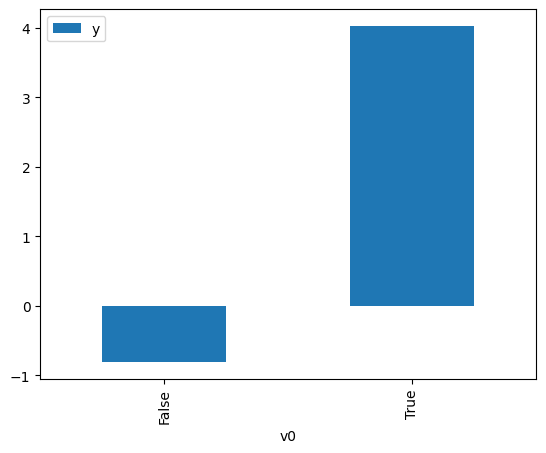

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

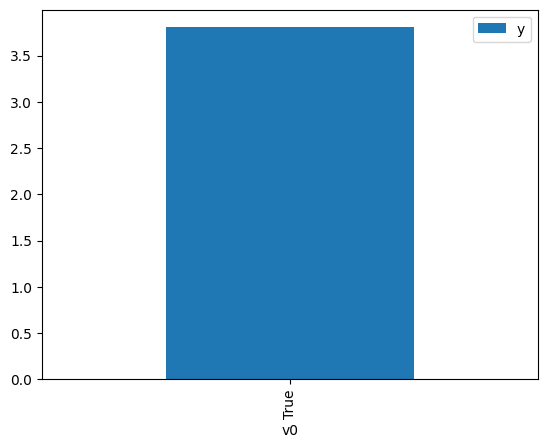

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.144154,False,1.576891,0.454240,2.201479
1,0.443734,False,1.150614,0.339762,2.943232
2,-1.421523,False,-2.684433,0.911269,1.097371
3,-1.031431,False,-1.651359,0.845947,1.182107
4,0.038231,False,1.018599,0.496611,2.013647
...,...,...,...,...,...
995,0.398076,False,1.211301,0.356388,2.805931
996,-1.579003,False,-2.328576,0.929692,1.075625
997,-0.999570,False,-1.315195,0.839165,1.191661
998,-0.644023,False,-1.046259,0.746760,1.339119


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.951432,True,2.150048,0.171537,5.829638
1,-1.077715,True,2.477417,0.144619,6.914721
2,-1.124675,True,4.810409,0.135543,7.377723
3,-0.361349,True,3.975826,0.348024,2.873366
4,-1.441561,True,2.855051,0.086165,11.605650
...,...,...,...,...,...
995,0.181724,True,4.751500,0.560662,1.783606
996,-2.661338,True,-0.017964,0.013138,76.115531
997,-2.021829,True,3.169825,0.035824,27.914614
998,-0.674430,True,2.293919,0.244123,4.096293


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              6887.
Date:                Sat, 12 Jul 2025   Prob (F-statistic):                        0.00
Time:                        13:31:30   Log-Likelihood:                         -1394.1
No. Observations:                1000   AIC:                                      2792.
Df Residuals:                     998   BIC:                                      2802.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6532      0.027     60.169      0.000       1.599       1.707
x2             4.9503      0.052     94.549      0.000       4.848       5.053
==============================================================================
Omnibus:                        1.025   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                1.055
Skew:                          -0.004   Prob(JB):                        0.590
Kurtosis:                       2.841   Cond. No.                         1.92
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""